# Scikit-learn Beginner's Template

_[...general description of the notebook...]_

---

## Selected Machine Learning References
_[...extend or outsource this list...]_

### Scikit-learn

* Documentation: http://scikit-learn.org/stable/documentation.html
* User guide: http://scikit-learn.org/stable/user_guide.html

### ML and Python

* Python Data Science Handbook, Jake VanderPlas: https://github.com/jakevdp/PythonDataScienceHandbook

### ML in general

* List of HEP-ML resources: https://github.com/iml-wg/HEP-ML-Resources
* Stanford lecture series on Machine Learning by Andrej Karpathy: https://www.youtube.com/playlist?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC

---

## Example Analysis

_[...general description of this analysis...]_

### Preparatory Steps

In [1]:
import math
import itertools

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import pandas as pd
from pandas.tools.plotting import scatter_matrix, radviz

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Data Import

_[...rephrase this paragraph...]_

Use the Higgs data set from https://archive.ics.uci.edu/ml/datasets/HIGGS.

Data description (taken from the website):

_"The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. [...]"_

In [3]:
attributes = [
    'class_label', # 1 for signal, 0 for background
    ##########################################################
    'lepton1_pT', # vvv  low-level features (columns 1-22)  vvv
    'lepton1_eta',
    'lepton1_phi',
    'missing_energy_mag',
    'missing_energy_phi',
    'jet1_pT',
    'jet1_eta',
    'jet1_phi',
    'jet1_btag',
    'jet2_pT',
    'jet2_eta',
    'jet2_phi',
    'jet2_btag',
    'jet3_pT',
    'jet3_eta',
    'jet3_phi',
    'jet3_btag',
    'jet4_pT',
    'jet4_eta',
    'jet4_phi',
    'jet4_btag', # ^^^  low-level features  ^^^
    ########################################################
    'm_jj', # vvv  high-level features (columns 22--28)  vvv
    'm_jjj',
    'm_lv',
    'm_jlv',
    'm_bb',
    'm_wbb',
    'm_wwbb' # ^^^  high-level features  ^^^
]

data = pd.read_csv('./data/higgs/HIGGS.csv',
                   header=None,
                   sep=',',
                   names=attributes,
                   usecols=[0,22,23,24,25,26,27,28],
                   nrows=500000)

X = data.drop(['class_label'], axis=1)
y = (data['class_label']).astype(int)

In [4]:
print('Dimensions of feature matrix X: ', X.shape)
print('Dimensions of target vector y:  ', y.shape)

print('\nTotal number of events in data sample: %d' % X.shape[0])
print('Number of signal events in data sample: %d (%.2f percent)' % (y[y==1].shape[0], y[y==1].shape[0]*100/y.shape[0]))
print('Number of backgr events in data sample: %d (%.2f percent)' % (y[y==0].shape[0], y[y==0].shape[0]*100/y.shape[0]))

Dimensions of feature matrix X:  (500000, 7)
Dimensions of target vector y:   (500000,)

Total number of events in data sample: 500000
Number of signal events in data sample: 264703 (52.94 percent)
Number of backgr events in data sample: 235297 (47.06 percent)


---

### Data Visualization

In order to get to know the dataset we are working with, we will create several different plots before doing the actual machine learning (ML) later on.

#### Histograms of the variables

As a first step, let's visualize the distributions of the respective variables of the dataset. We can do this by creating histograms of the variable distributions for (1) the positive class ('signal events') and (2) the negative class ('background events').

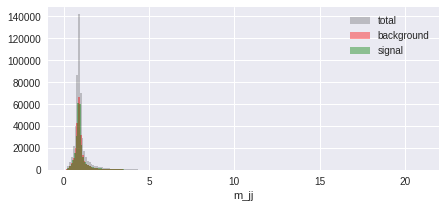

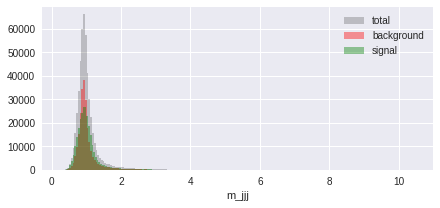

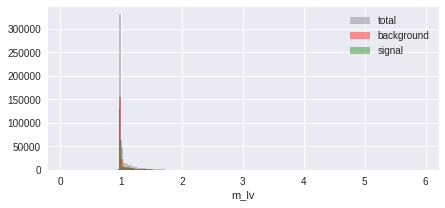

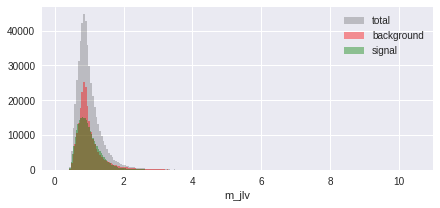

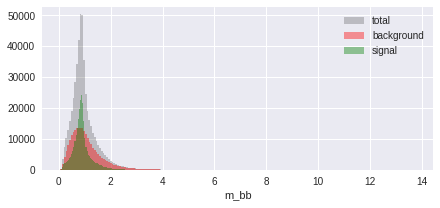

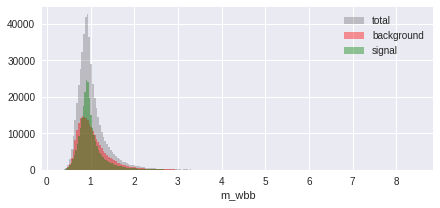

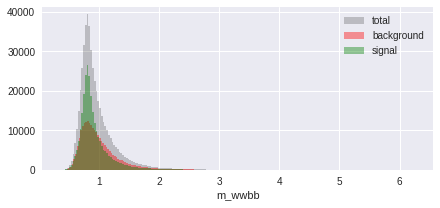

In [5]:
for i in range(1,data.columns.size):
    plt.figure(figsize=(7,3))
    plt.hist(data[data.columns[i]],
             bins=200, alpha=.2, color='black', label='total')
    plt.hist(data[data['class_label']==0.0][data.columns[i]].reset_index(drop=True),
             bins=200, alpha=.4, color='red', label='background')
    plt.hist(data[data['class_label']==1.0][data.columns[i]].reset_index(drop=True),
             bins=200, alpha=.4, color='green', label='signal')
    plt.xlabel(data.columns[i])
    plt.legend()
    plt.show()

Ideally, the respective distributions are different for the two classes, such that signal and background events can be distinguished easily by setting cuts on one or many variables (without necessarily employing machine learning at all). In many cases - like in our dataset - it is difficult to do this because of the similarities of the signal and background distributions. Here, ML techniques are able to show their strengths thanks to their multivariate nature and their ability to exploit correlations between variables.

#### Scatter matrix

We can extract even more information from the data by plotting a so-called "scatter matrix". This matrix visualizes relationships between the input features.

Since we know that the matrix diagonal elements are represented by straight lines at 45 degrees (due to the 1:1 correlation of the variables with themselves), we replace these elements by the "kernel density estimations" of the respective features.

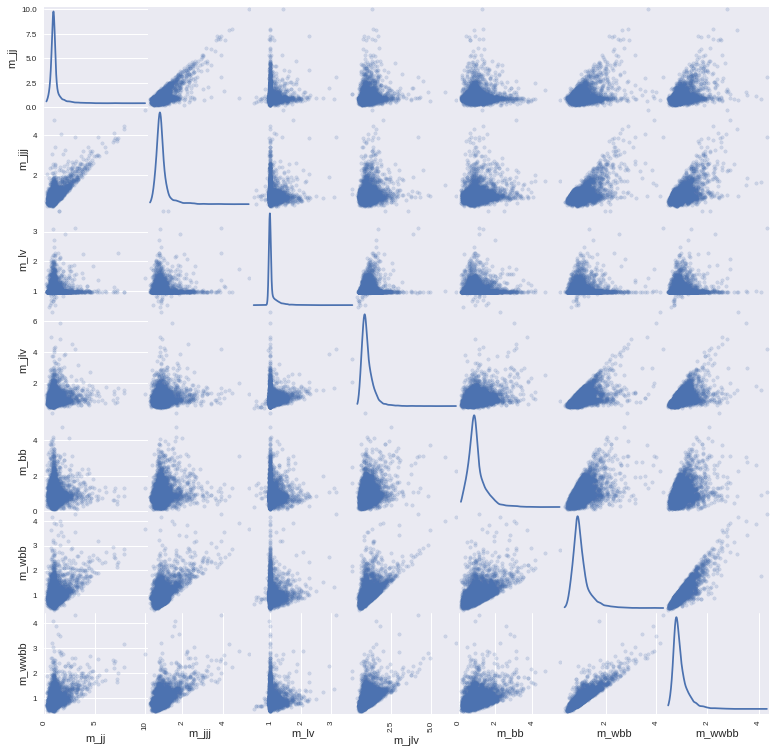

In [6]:
scatter_matrix(data.ix[0:5000,1:28], figsize=(13,13), diagonal='kde', alpha=.2)
plt.show()

#### Correlation Matrix

Another way of displaying relationships between the input features is to compute their "correlation matrix".

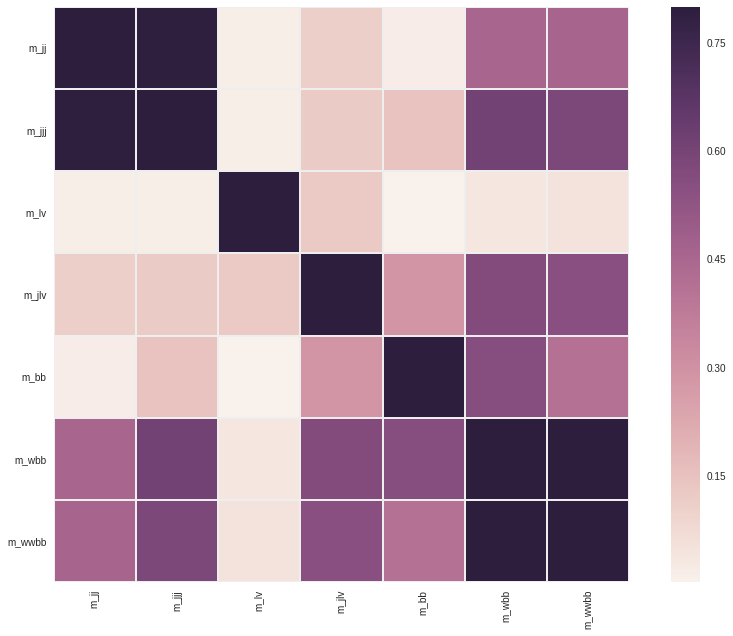

In [7]:
plt.figure()
plt.subplots(figsize=(12,9))
sns.heatmap(X.corr(), vmax=.8, square=True, linewidths=1, linecolor='#eeeeee')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout();

#### RadViz

_RadViz is a way of visualizing multi-variate data. It is based on a simple spring tension minimization algorithm. Basically you set up a bunch of points in a plane. In our case they are equally spaced on a unit circle. Each point represents a single attribute. You then pretend that each sample in the data set is attached to each of these points by a spring, the stiffness of which is proportional to the numerical value of that attribute (they are normalized to unit interval). The point in the plane, where our sample settles to (where the forces acting on our sample are at an equilibrium) is where a dot representing our sample will be drawn. Depending on which class that sample belongs it will be colored differently._ (Source: [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/visualization.html#radviz):)

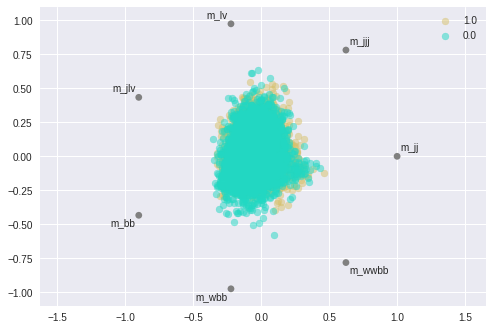

In [8]:
radviz(data.ix[0:10000,:], 'class_label', alpha=.5)

---

### Data Preprocessing

_[...explain standard scaling...]_

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

print('Mean values of transformed data: \n', scaler.mean_)
print('Variance of transformed data: \n', scaler.var_)
print('Scale of transformed data: \n', scaler.scale_)

Mean values of transformed data: 
 [ 1.03443565  1.02438126  1.05065757  1.00998364  0.97339844  1.0332645
  0.95986239]
Variance of transformed data: 
 [ 0.446436    0.14264257  0.02706035  0.15833973  0.27636289  0.13293931
  0.0980927 ]
Scale of transformed data: 
 [ 0.66815866  0.37768051  0.1645003   0.39791925  0.52570228  0.36460843
  0.31319754]


### Data Split Into Training, Validation and Test Sample

_[...explain the implemented data splitting...]_

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2,
                                                  random_state=43)

print('Number of training samples:   %d' % X_train.shape[0])
print('Number of validation samples: %d' % X_val.shape[0])
print('Number of test samples:       %d' % X_test.shape[0])

Number of training samples:   400000
Number of validation samples: 100000
Number of test samples:       100000


### Model Definition

_[...very briefly explain the random forest classifier...]_

In [11]:
clf = RandomForestClassifier(n_estimators=500,
                             criterion='gini',
                             max_depth=None,
                             min_samples_split=500,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features=None,
                             max_leaf_nodes=None,
                             min_impurity_split=1e-07,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=-1,
                             random_state=None,
                             verbose=0,
                             warm_start=False,
                             class_weight=None)

### Model Training

In [12]:
clf = clf.fit(X_train, y_train)

print("Accuracy on training set:   {:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy on validation set: {:.3f}".format(clf.score(X_val, y_val)))

Accuracy on training set:   0.720
Accuracy on validation set: 0.703


_[...briefly explain the variable importance plot...]_

Feature ranking:
	1. m_jlv 	(0.384863)
	2. m_wbb 	(0.179074)
	3. m_bb 	(0.133643)
	4. m_lv 	(0.119661)
	5. m_jj 	(0.108207)
	6. class_label 	(0.054250)
	7. m_jjj 	(0.020302)


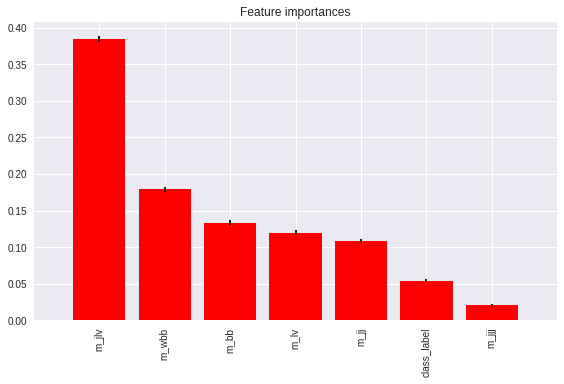

In [13]:
# feature importances

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
    
# Print the feature ranking
print("Feature ranking:")
    
indices_featureNames = np.empty([X_train.shape[1]], dtype=object)
    
for f in range(X_train.shape[1]):
    indices_featureNames[f] = data.columns[indices[f]]
    print("\t%d. %s \t(%f)" % (f + 1,
                               indices_featureNames[f],
                               importances[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]),
        importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices_featureNames, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

---

### Model Evaluation on the Validation Sample

_[...shorty introductory paragraph...]_

In [14]:
# definition of general plotting parameters
nbins = 100

In [15]:
y_val_score = clf.predict_proba(X_val)

#### MVA output distribution

_[...explain the following plot...]_

In [16]:
def plot_MVAoutput(y_truth, y_score, nbins=100):
    """
    Plots the MVA output as histogram and returns the underlying
    distributions of the positive and the negative class.
    """
    
    y_score_negClass, y_score_posClass = np.split(y_score,
                                                  2,
                                                  axis=1)
    
    y_score_posClass_truePos = y_score_posClass[np.array(y_truth==1)]
    y_score_posClass_trueNeg = y_score_posClass[np.array(y_truth==0)]
    
    plt.figure()

    n_total, bins_total, patches_total = \
        plt.hist(y_score[:,1],
                 bins=nbins,
                 alpha=.25,
                 color='black',
                 label='MVA output')
    
    n_trueNeg, bins_trueNeg, patches_trueNeg = \
        plt.hist(y_score_posClass_trueNeg,
                 bins=nbins,
                 alpha=0.5,
                 color='#dd0000',
                 label='true negative')
    
    n_truePos, bins_truePos, patches_truePos = \
        plt.hist(y_score_posClass_truePos,
                 bins=nbins,
                 alpha=0.5,
                 color='green',
                 label='true positive')
    
    plt.title('MVA output distribution (positive class)')
    plt.xlim(-0.05, 1.05)
    plt.xlabel('MVA output')
    plt.ylabel('Entries')
    plt.legend()
    
    return n_truePos, n_trueNeg

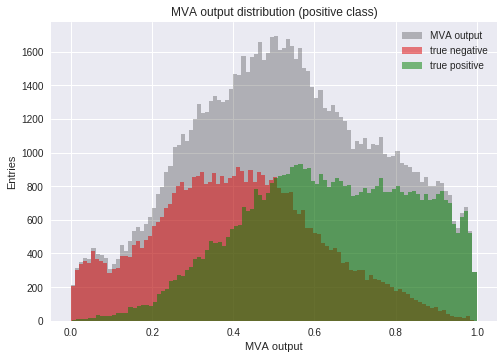

In [17]:
n_truePos, n_trueNeg = plot_MVAoutput(y_val, y_val_score, nbins)

#### Cut efficiencies plot / MVA cut optimization

_[...explain the following plot...]_

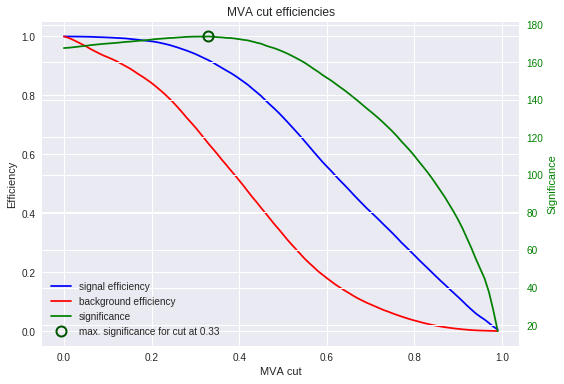

In [18]:
MVAcut = np.empty((0))

plt.figure()
fig, ax1 = plt.subplots()
signal_efficiency = np.empty((0))
backgr_efficiency = np.empty((0))
for i in range(nbins):
    signal_efficiency = np.append(signal_efficiency, \
                                  np.sum(n_truePos[i:n_truePos.shape[0]]) / np.sum(n_truePos))
    backgr_efficiency = np.append(backgr_efficiency, \
                                  np.sum(n_trueNeg[i:n_trueNeg.shape[0]]) / np.sum(n_trueNeg))
    MVAcut = np.append(MVAcut, i/(nbins*1.0))
l1 = ax1.plot(MVAcut, signal_efficiency, label='signal efficiency', color='blue')
l2 = ax1.plot(MVAcut, backgr_efficiency, label='background efficiency', color='red')
ax1.set_xlabel('MVA cut')
ax1.set_ylabel('Efficiency')

ax2 = ax1.twinx()
significance_per_MVAcut = np.empty((0))
for i in range(nbins):
    significance_per_MVAcut = np.append(significance_per_MVAcut, \
                                        np.sum(n_truePos[i:n_truePos.shape[0]]) / \
                                        math.sqrt(np.sum(n_truePos[i:n_truePos.shape[0]] + \
                                                         n_trueNeg[i:n_trueNeg.shape[0]])))
    
l3 = ax2.plot(MVAcut, significance_per_MVAcut,
              label='significance',
              color='green')
pos_max = np.argmax(significance_per_MVAcut)
threshold_pos_max = pos_max/(nbins*1.0)
l4 = ax2.plot(pos_max/(nbins*1.0), significance_per_MVAcut[pos_max],
              label='max. significance for cut at %.2f' % threshold_pos_max,
              marker='o', markersize=10, fillstyle='none', mew=2, linestyle='none',
              color='#005500')
ax2.set_ylabel('Significance', color='green')
ax2.tick_params('y', colors='green')

plt.title('MVA cut efficiencies')
lall = l1+l2+l3+l4
labels = [l.get_label() for l in lall]
ax2.legend(lall, labels, loc='lower left')
plt.tight_layout()

#### ROC curve

_[...explain the following plot...]_

In [19]:
def plot_ROCcurve(y_truth, y_score, workingpoint=-1):
    """
    Plots the ROC curve and (if specified) the chosen working point.
    """
    
    fpr, tpr, thresholds = roc_curve(y_truth, y_score[:,1], pos_label=1)
    roc_auc = roc_auc_score(y_truth, y_score[:,1])
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    
    if workingpoint != -1:
        # find and plot threshold closest to the chosen working point
        close_threshold_pos_max = np.argmin(np.abs(thresholds-workingpoint))
    
        plt.plot(fpr[close_threshold_pos_max], tpr[close_threshold_pos_max], 'o', markersize=10,
                 label="threshold at %.2f" % workingpoint, fillstyle="none",
                 mew=2)
    
    plt.legend(loc=4)

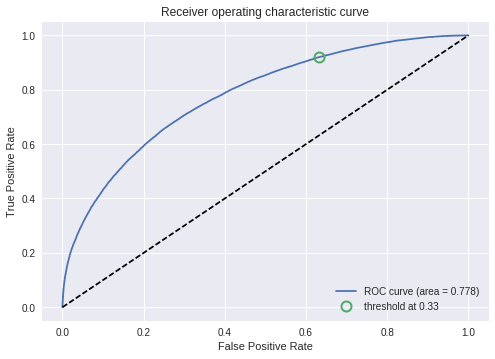

In [20]:
plot_ROCcurve(y_val, y_val_score, threshold_pos_max)

#### Precision-recall curve

_[...explain the following plot...]_

In [21]:
def plot_precision_recall_curve(y_truth, y_score, workingpoint=-1):
    """
    Plots the precision-recall curve.
    """
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    precision, recall, thresholds_PRC = \
        precision_recall_curve(y_truth,
                               y_score[:,1])
    
    average_precision = average_precision_score(y_truth, y_score[:,1])
    
    # Plot Precision-Recall curve
    n_classes=1
    
    plt.figure()
    plt.plot(recall, precision, lw=2,
             label='Precision-recall curve of signal class (area = {1:0.2f})'
                    ''.format(1, average_precision))
    
    if workingpoint != -1:
        # find threshold closest to the chosen working point
        close_optimum = np.argmin(np.abs(thresholds_PRC-workingpoint))
        
        plt.plot(recall[close_optimum], precision[close_optimum],
                 'o',
                 markersize=10,
                 label="threshold at %.2f" % workingpoint,
                 fillstyle="none",
                 mew=2)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel(r'Recall $R=T_p / (T_p+F_n)$')
    plt.ylabel(r'Precision $P=T_p / (T_p+F_p)$')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")

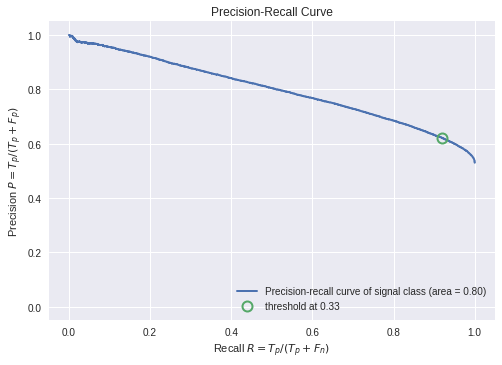

In [22]:
plot_precision_recall_curve(y_val, y_val_score, threshold_pos_max)

#### Confusion matrix

_[...explain the following plot...]_

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. If 'normalize' is set 'True',
    the output matrix will contain percentages instead of
    absolute numbers.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [24]:
# Compute confusion matrix
y_val_score_labels = (y_val_score[:,1] > threshold_pos_max)
cnf_matrix = confusion_matrix(y_val, y_val_score_labels)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[17249 29739]
 [ 4223 48789]]


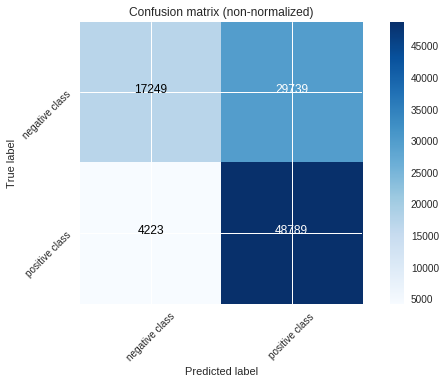

In [25]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['negative class','positive class'],
                      title='Confusion matrix (non-normalized)')

Normalized confusion matrix
[[ 0.37  0.63]
 [ 0.08  0.92]]


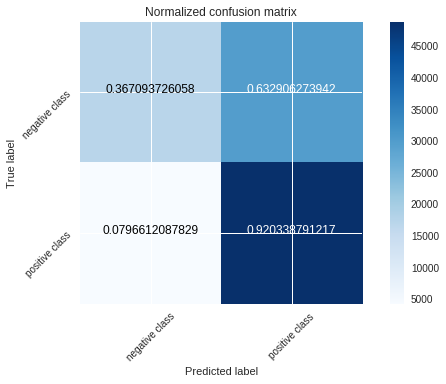

In [26]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['negative class','positive class'],
                      normalize=True,
                      title='Normalized confusion matrix')

#### Classification report

_[...explain the meaning of this report...]_

In [27]:
print(classification_report(y_val, y_val_score_labels,
                            target_names=['negative class','positive class']))

                precision    recall  f1-score   support

negative class       0.80      0.37      0.50     46988
positive class       0.62      0.92      0.74     53012

   avg / total       0.71      0.66      0.63    100000



---

### Model Application to the Test Sample

_[...brief introductory paragraph...]_

In [28]:
y_test_score = clf.predict_proba(X_test)

#### MVA output distribution

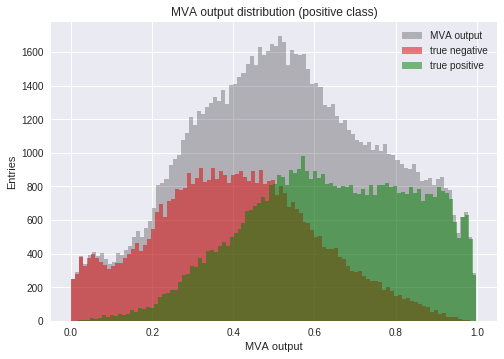

In [29]:
n_truePos, n_trueNeg = plot_MVAoutput(y_test, y_test_score)

#### ROC curve

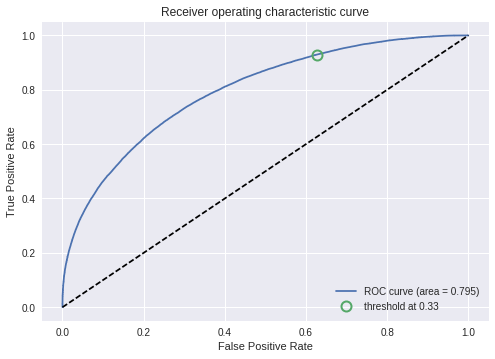

In [30]:
plot_ROCcurve(y_test, y_test_score, threshold_pos_max)

#### Precision-recall curve

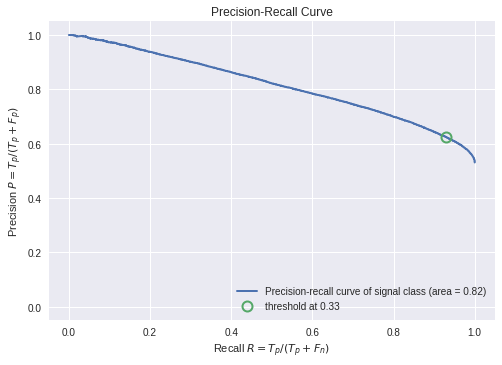

In [31]:
plot_precision_recall_curve(y_test, y_test_score, threshold_pos_max)

#### Confusion matrix

In [32]:
# Compute confusion matrix
y_test_score_labels = (y_test_score[:,1] > threshold_pos_max)
cnf_matrix = confusion_matrix(y_test, y_test_score_labels)
np.set_printoptions(precision=2)

Normalized confusion matrix
[[ 0.37  0.63]
 [ 0.07  0.93]]


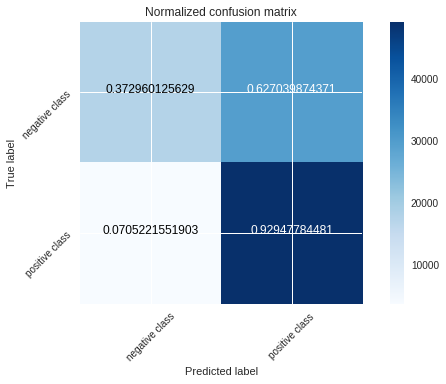

In [33]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['negative class','positive class'],
                      normalize=True,
                      title='Normalized confusion matrix')

#### Classification report

In [34]:
print(classification_report(y_test, y_test_score_labels,
                            target_names=['negative class','positive class']))

                precision    recall  f1-score   support

negative class       0.82      0.37      0.51     47123
positive class       0.62      0.93      0.75     52877

   avg / total       0.72      0.67      0.64    100000

